Land Use Land Cover Map Generation

In [1]:
! pip install -r ../requirements.txt

In [2]:
import sys
import os
sys.path.append('C:/Users/Sania Serrao/projects/LULCmapsGen/src')
import requests
import json

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping libraries
import ee #earth engine
import eeconvert as eec
import geemap
import folium


import torch
from torchvision import datasets, models, transforms

from selenium import webdriver
     

In [3]:
from utils import load_model
from geo_plot import plot_lulc_map
from predict_crop import predict_crop
from color_map import color_map
from visualize_lulc import visualize_lulc
from export_lulc import export_lulc


In [4]:
roi='Delhi Cantonment'
img_path='C:/Users/Sania Serrao/projects/LULCmapsGen/images/sentinel2_Delhi Cantonment/sentinel2_Delhi Cantonment_RGB.tif'
geobound=gpd.read_file("C:/Users/Sania Serrao/projects/LULCmapsGen/data/geoboundaryIND_ADM3.geojson")
region=geobound.loc[geobound.shapeName == roi]
centroid = region.iloc[0].geometry.centroid.coords[0]
tiles=gpd.read_file("C:/Users/Sania Serrao/projects/LULCmapsGen/data/Delhi Cantonment.geojson")



In [5]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = "C:/Users/Sania Serrao/projects/LULCmapsGen/models/best_model.pth"



model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

c:\Users\Sania Serrao\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sania Serrao\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Sania Serrao\AppData\Local\Temp\ipykernel_8264\3653512685.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary

Model file C:/Users/Sania Serrao/projects/LULCmapsGen/models/best_model.pth successfully loaded.


In [6]:
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(img_path, [tiles.iloc[index]['geometry']], model)
  labels.append(label)
tiles['pred'] = labels


filepath = os.path.join("C:/Users/Sania Serrao/projects/LULCmapsGen/predictions", "{}_preds.geojson".format(roi))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(5)
     

  0%|          | 0/408 [00:00<?, ?it/s]

,id,geometry,pred
0,delhi cantonment_0,"POLYGON ((77.05605 28.63676, 77.05605 28.64251...",None
1,delhi cantonment_1,"POLYGON ((77.05605 28.63101, 77.05605 28.63676...",None
2,delhi cantonment_2,"POLYGON ((77.05605 28.62527, 77.05605 28.63101...",None
3,delhi cantonment_3,"POLYGON ((77.05605 28.61952, 77.05605 28.62527...",None
4,delhi cantonment_4,"POLYGON ((77.05605 28.61377, 77.05605 28.61952...",None


In [7]:
tiles=gpd.read_file("C:/Users/Sania Serrao/projects/LULCmapsGen/predictions/Delhi Cantonment_preds.geojson")

In [8]:
color_tiles=color_map(tiles)
color_tiles.head(2)

,id,pred,geometry,color
0,delhi cantonment_0,None,"POLYGON ((77.05605 28.63676, 77.05605 28.64251...",#000000
1,delhi cantonment_1,None,"POLYGON ((77.05605 28.63101, 77.05605 28.63676...",#000000


In [9]:
map=visualize_lulc(centroid,region,color_tiles)
map

In [10]:
export_lulc('C:/Users/Sania Serrao/projects/LULCmapsGen/maps',roi,map)

TIFF file saved as C:/Users/Sania Serrao/projects/LULCmapsGen/maps\Delhi Cantonment\lulc_mapDelhi Cantonment.tiff


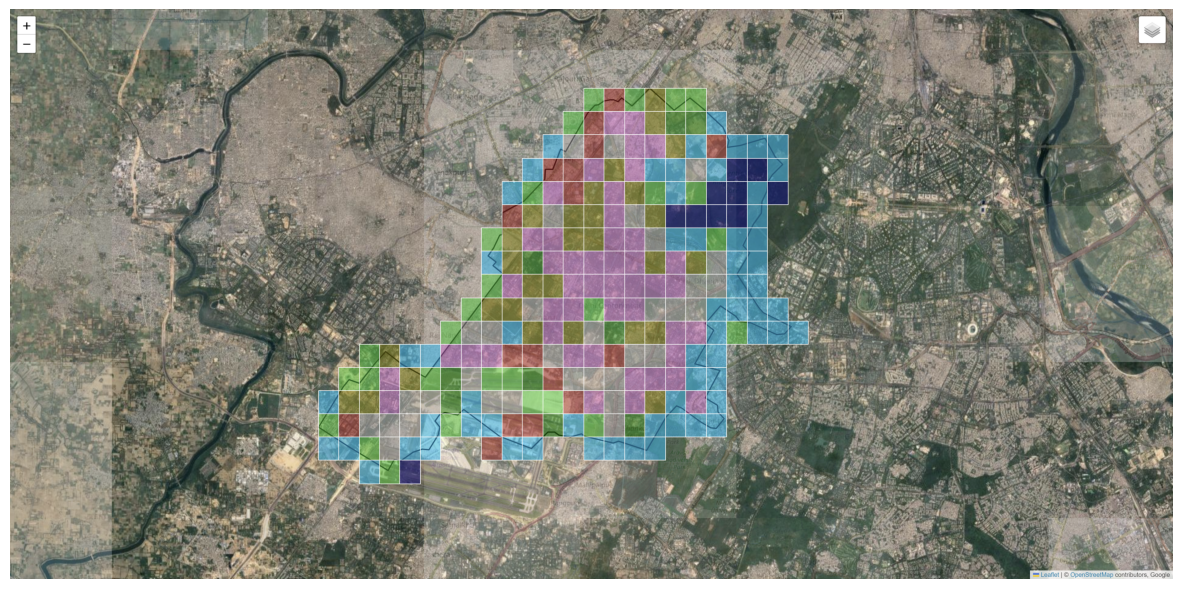

In [12]:
plot_lulc_map("C:/Users/Sania Serrao/projects/LULCmapsGen/maps/Delhi Cantonment/lulc_mapDelhi Cantonment.tiff")